In [1]:
import numpy as np
import pandas as pd
import statsmodels.stats.multitest as smm
import scipy.stats as scs

import math
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [2]:
collins = pd.read_csv('<Path to Collins dataframe of pHI and pTS scores for each gene>', sep='\t', decimal=',')
collins['Diff_collins'] = collins.pTS - collins.pHI

print(collins.head())
print('Correlation pHI and pTS = {}'.format(scs.spearmanr(collins.pTS, collins.pHI)))

     gene      pHI      pTS  Diff_collins
0    LRP1  0.99168  1.00000       0.00832
1    ANK3  1.00000  0.98212      -0.01788
2   PRMT1  0.91325  0.99998       0.08673
3   SF3B1  0.99539  0.99995       0.00456
4  SPTAN1  0.99409  0.99994       0.00585
Correlation pHI and pTS = SignificanceResult(statistic=0.7130864028881185, pvalue=0.0)


In [3]:
gene_scores = pd.read_csv('<Path to the list of genes coming from the whole genome with their scores>',usecols=['gene_id', 'gene', 'oe_lof_upper'], sep='\t')

In [4]:
loeuf_collins = pd.merge(collins, gene_scores, on='gene', how = 'left')
print(loeuf_collins.head())
print('Correlation pHI and LOEUF = {}'.format(scs.spearmanr(loeuf_collins.pHI, loeuf_collins.oe_lof_upper, nan_policy='omit')))
print('Correlation pTS and LOEUF = {}'.format(scs.spearmanr(loeuf_collins.pTS, loeuf_collins.oe_lof_upper, nan_policy='omit')))

     gene      pHI      pTS  Diff_collins          gene_id  oe_lof_upper
0    LRP1  0.99168  1.00000       0.00832  ENSG00000123384         0.058
1    ANK3  1.00000  0.98212      -0.01788  ENSG00000151150         0.089
2   PRMT1  0.91325  0.99998       0.08673  ENSG00000126457         0.148
3   SF3B1  0.99539  0.99995       0.00456  ENSG00000115524         0.066
4  SPTAN1  0.99409  0.99994       0.00585  ENSG00000197694         0.101
Correlation pHI and LOEUF = SignificanceResult(statistic=-0.8472582228567471, pvalue=0.0)
Correlation pTS and LOEUF = SignificanceResult(statistic=-0.7361450330974233, pvalue=0.0)


In [5]:
# Load the data and filter it to keep only the relevant data
data_go = pd.read_csv('<Path to the GO terms effect sizes on cognitive ability when deleted and duplicated>', usecols=lambda column: column not in ['carriers'], sep='\t')
data_go['coverage'] =  data_go.n_unique_genes / data_go.gene_list_n
data_go_clean = data_go[(data_go.cat == 'g') &
                        (data_go.ancestry == 'All') &
                         (data_go.diagnosis == 'wo_ASD') &
                        (data_go.gene_list_n >= 10) &
                        (data_go.gene_list_n < 500) &
                        (data_go.max_score == 10000) &
                        (data_go.total_carriers >= 30) & 
                        (data_go.model_type == '1_3') & 
                       (data_go.coverage >= 0.20) 
                           ]

data_all =  data_go_clean

In [6]:
# Compute the adjusted p-values (FDR correction) for each gene list
new_data = pd.DataFrame()
for cnv_type in data_all.TYPE.unique():
    for combo in set(zip(data_all['model_type'], data_all['win'],  data_all['diagnosis'])):
        tmp = data_all[(data_all.TYPE==cnv_type) & (data_all.model_type==combo[0]) & (data_all.win==combo[1]) & (data_all.diagnosis==combo[2])].copy()
        tmp['pvalue_adj'] = smm.fdrcorrection(tmp['pvalue'])[1]
        new_data = pd.concat([new_data, tmp])
        
print(new_data.gene_list_name.nunique())

6130


In [7]:
# Prepare the data for the tagDS computation on our genesets of interest
ratio = 0.426609501927956 # Ratio of differences between average effect of DEL and DUP on cognitive ability
def compute_tagDS(es_data, data_CNV, a=1, b=-1, c=0):
    tagDS_vals = []
    for i, row in es_data.iterrows():
        distance = abs(a*row.Estimate_DEL + b*row.Estimate_DUP + c)/math.sqrt((a**2)+(b**2))
        delta_y = a*row.Estimate_DEL - row.Estimate_DUP
        if (delta_y > 0) & (a > 0):
            distance = -distance
        tagDS_vals.append(distance)
    es_data['tagDS'] = tagDS_vals 
    random_distri_tagDS = pd.read_csv('<Path to list of normalized tagDS for each geneset sizes>', sep='\t')
    tmp_data = pd.merge(es_data, data_CNV[data_CNV.TYPE=='DEL'].loc[:,['gene_list_name', 'gene_list_n']], on='gene_list_name', how='inner')

    tmp = pd.merge(tmp_data, random_distri_tagDS[['size', 'mu_s', 'sd_s']], left_on='gene_list_n', right_on='size', how='inner')
    tmp['zTagDS'] = (tmp['tagDS'] - tmp['mu_s'])/tmp['sd_s']
    return tmp

In [8]:
data_pivot = new_data.pivot(columns='TYPE', values=['Estimate', 'pvalue_adj', 'unique_genes'], index='gene_list_name')
print(data_pivot.shape)
data_pivot = data_pivot[(data_pivot.pvalue_adj.DEL <= 0.05) | (data_pivot.pvalue_adj.DUP <= 0.05)]
print(data_pivot.Estimate.DEL.describe())
print(data_pivot.Estimate.DUP.describe())
data_pivot.dropna(inplace=True)
data_pivot.columns = ['Estimate_DEL', 'Estimate_DUP', 'pvalue_adj_DEL', 'pvalue_adj_DUP', 'unique_genes_DEL', 'unique_genes_DUP']
data_pivot = compute_tagDS(data_pivot, new_data, ratio)
data_pivot['genes'] = data_pivot.unique_genes_DEL + data_pivot.unique_genes_DUP
print(data_pivot.shape)

(6130, 6)
count     645.000000
unique    622.000000
top        -0.143999
freq        3.000000
Name: DEL, dtype: float64
count     769.000000
unique    759.000000
top        -0.554927
freq        3.000000
Name: DUP, dtype: float64
(645, 14)


In [9]:
diffs = []
pHIs = []
pTSs = []
loeufs = []
for i, row in data_pivot.iterrows():
    genes = row.genes.split(',')
    unique_genes = set(genes)
    tmp_genes = gene_scores[gene_scores.gene_id.isin(unique_genes)]
    tmp_genes = pd.merge(tmp_genes, collins, on='gene')
    loeufs.append(tmp_genes.oe_lof_upper.mean())
    diffs.append(tmp_genes.Diff_collins.mean())
    pHIs.append(tmp_genes.pHI.mean())
    pTSs.append(tmp_genes.pTS.mean())

In [10]:
data_pivot['LOEUF'] = loeufs
data_pivot['pHI'] = pHIs
data_pivot['pTS'] = pTSs
data_pivot['Collins'] = diffs

In [30]:
colors_del = plt.cm.Reds(np.linspace(0, 1, 256))
colors_dup = plt.cm.Blues(np.linspace(1, 0, 256))
all_colors = np.vstack((colors_dup, colors_del))
del_dup_spe = colors.LinearSegmentedColormap.from_list('del_dup_spe', all_colors)

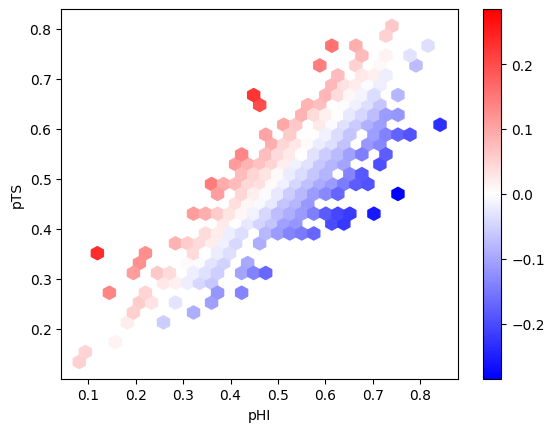

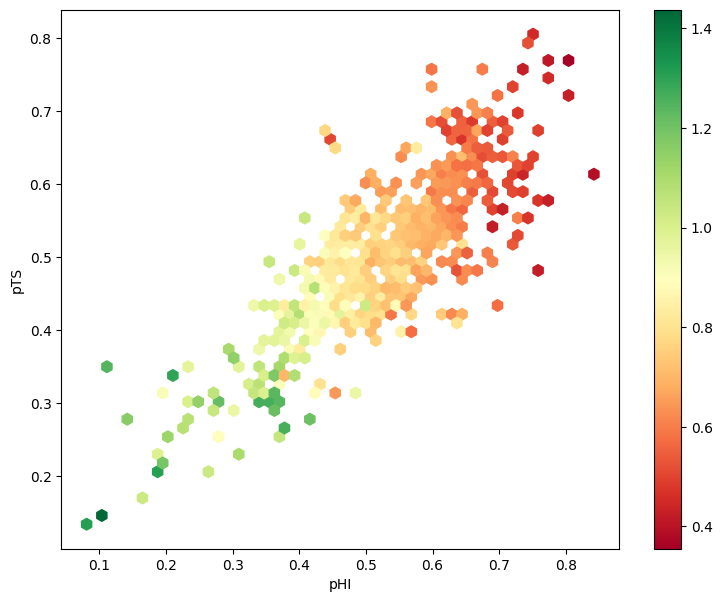

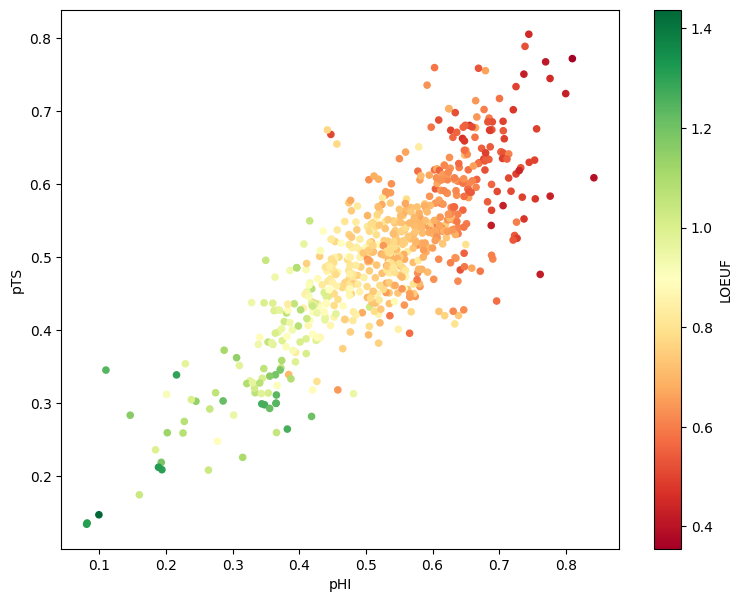

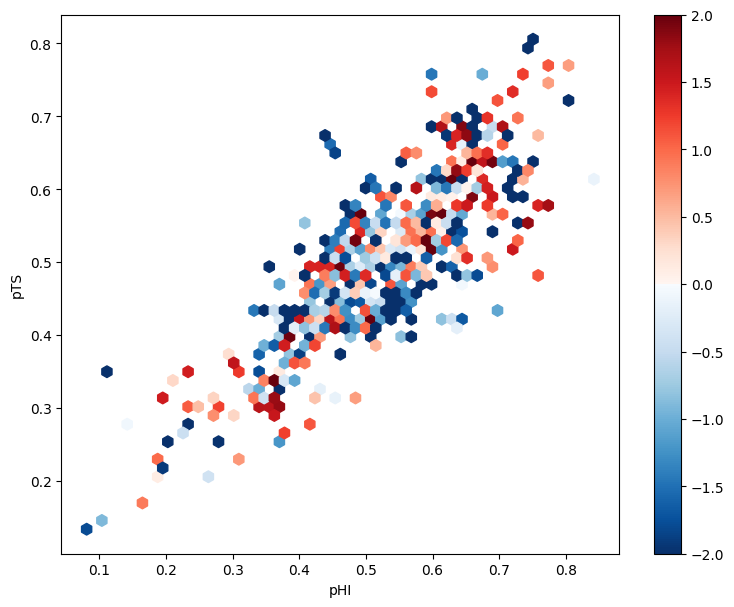

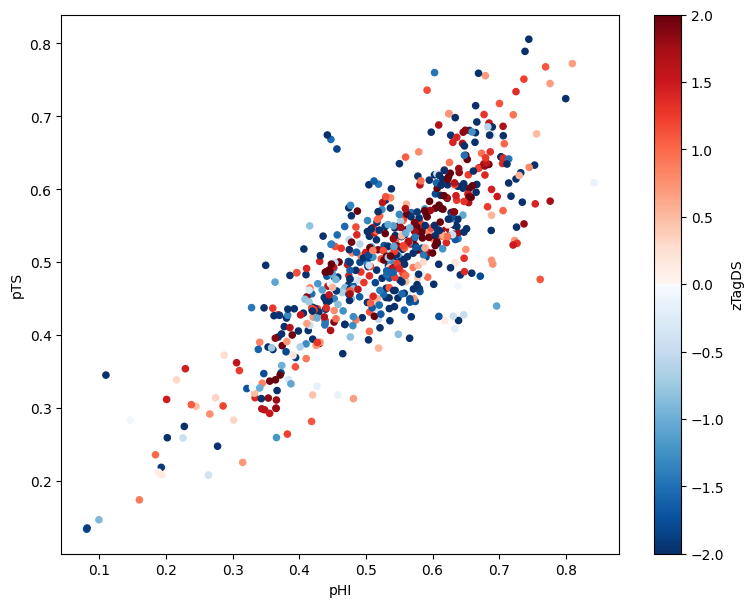

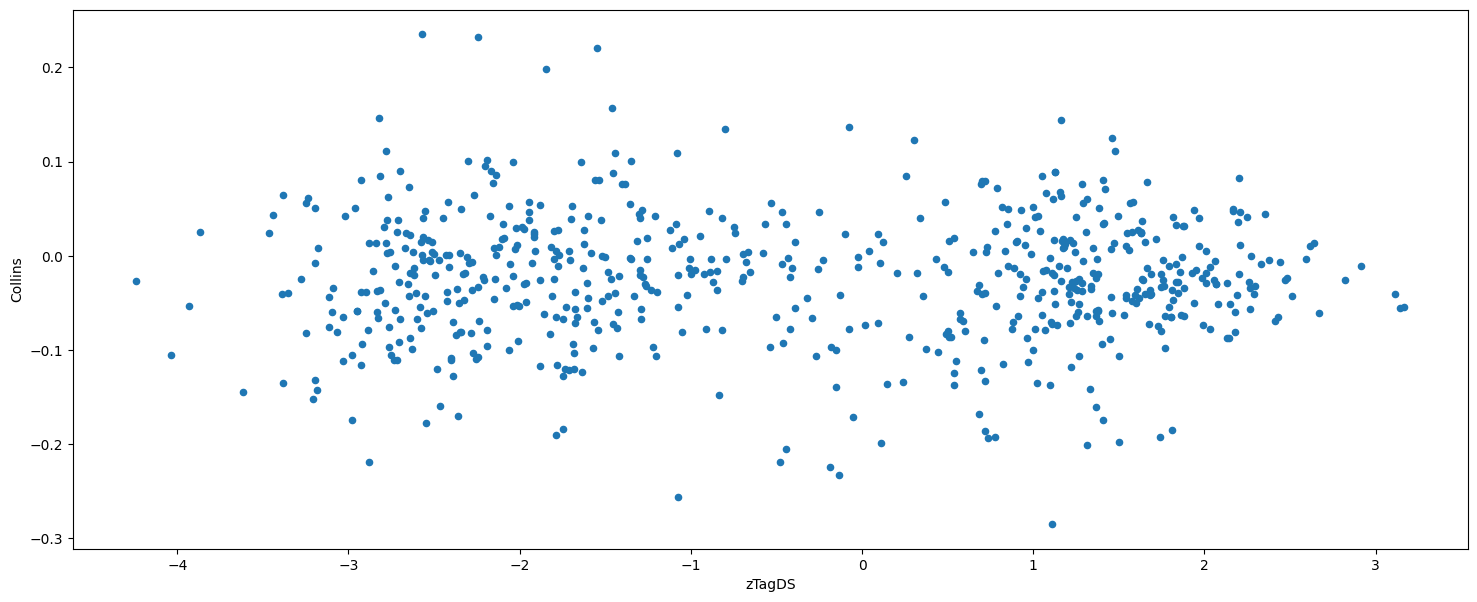

SignificanceResult(statistic=0.007797001936907738, pvalue=0.8433281501418763)
SignificanceResult(statistic=0.7854288881238762, pvalue=4.340415461142736e-136)
SignificanceResult(statistic=-0.9047913881160503, pvalue=1.4332515111437334e-240)
SignificanceResult(statistic=-0.7739658175294569, pvalue=1.0265291981250038e-129)


In [32]:
data_pivot.plot.hexbin(x='pHI', y='pTS', C='Collins', cmap='bwr', norm=colors.CenteredNorm(), gridsize=30)
plt.show()
fig, ax = plt.subplots(figsize=(9,7))
data_pivot.plot.hexbin(x='pHI', y='pTS', C='LOEUF', cmap='RdYlGn', gridsize=50, ax=ax)
plt.show()
fig, ax = plt.subplots(figsize=(9,7))
data_pivot.plot.scatter(x='pHI', y='pTS', c='LOEUF', cmap='RdYlGn', ax=ax)
plt.show()
fig, ax = plt.subplots(figsize=(9,7))
data_pivot.plot.hexbin(x='pHI', y='pTS', C='zTagDS', cmap=del_dup_spe, norm=colors.TwoSlopeNorm(vmin=-2, vcenter=0, vmax=2), gridsize=50, ax=ax)
plt.show()
fig, ax = plt.subplots(figsize=(9,7))
data_pivot.plot.scatter(x='pHI', y='pTS', c='zTagDS', cmap=del_dup_spe, norm=colors.TwoSlopeNorm(vmin=-2, vcenter=0, vmax=2),ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(18,7))
tmp = data_pivot.plot.scatter(x='zTagDS', y='Collins', ax=ax)
plt.show()


print(scs.spearmanr(data_pivot.zTagDS, data_pivot.Collins))
print(scs.spearmanr(data_pivot.pHI, data_pivot.pTS))
print(scs.spearmanr(data_pivot.LOEUF, data_pivot.pHI))
print(scs.spearmanr(data_pivot.LOEUF, data_pivot.pTS))